In [4]:
!pip uninstall umap -y
!pip install umap-learn

In [13]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [5]:
COLAB_WORKING_PATH = "/content/drive/My Drive/Colab Notebooks/Botanist" # Path to folder in Google Drive

# PATHS
DATASET_ZIP_PATH = COLAB_WORKING_PATH # Path to "herbier.zip"
DATASET_PATH = "/content/data/" # Where the unzipped data should land ?
WORD_DATA_PATH = "/content/data/herbier/data_public/words/"
METADATA_PATH = "/content/data/herbier/data_public/ascii/words.txt"

In [15]:
# Create our data folder, unzip the data
!mkdir $DATASET_PATH
!unzip "$DATASET_ZIP_PATH/herbier.zip" -d $DATASET_PATH
!cd "$DATASET_PATH/herbier"

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
  inflating: /content/data/herbier/data_public/words/r02/r02-131/r02-131-01-07.png  
  inflating: /content/data/herbier/data_public/words/r02/r02-131/r02-131-01-08.png  
  inflating: /content/data/herbier/data_public/words/r02/r02-131/r02-131-01-09.png  
  inflating: /content/data/herbier/data_public/words/r02/r02-131/r02-131-01-10.png  
  inflating: /content/data/herbier/data_public/words/r02/r02-131/r02-131-01-11.png  
  inflating: /content/data/herbier/data_public/words/r02/r02-131/r02-131-01-12.png  
  inflating: /content/data/herbier/data_public/words/r02/r02-131/r02-131-01-13.png  
  inflating: /content/data/herbier/data_public/words/r02/r02-131/r02-131-02-00.png  
  inflating: /content/data/herbier/data_public/words/r02/r02-131/r02-131-02-01.png  
  inflating: /content/data/herbier/data_public/words/r02/r02-131/r02-131-02-02.png  
  inflating: /content/data/herbier/data_public/words/r02/r02-131/r02-131

In [6]:
IMAGE_HEIGHT = IMAGE_WIDTH = 128

CLASSES = ['a01-000u', 'c03-000a']
N_CLASSES = len(CLASSES)

FLATTEN_LAYER_NAME = 'flattened'

DEBUG = True

In [7]:
import os

import numpy as np

import tensorflow as tf
import tensorflow.keras as keras
import matplotlib.pyplot as plt

import sklearn.model_selection as skms
import sklearn.preprocessing as skp
import sklearn.utils as sku
import sklearn.decomposition as skd
import sklearn.metrics as skm

from sklearn.manifold import TSNE

# Module for k-fold
from sklearn.model_selection import KFold

import umap.umap_ as umap

## TODO
- cross-validation
-
- voir pour ignorer le fichier METADATA
- prétraitement image
  - réduire spectre pixels
  - resize

Loaded 112 words.
  Writer ID: a01-000u; image shape: (51, 27, 1)
  Writer ID: a01-000u; image shape: (48, 213, 1)
  Writer ID: a01-000u; image shape: (50, 70, 1)
  Writer ID: a01-000u; image shape: (78, 166, 1)
  Writer ID: a01-000u; image shape: (61, 126, 1)
number of writers:  2


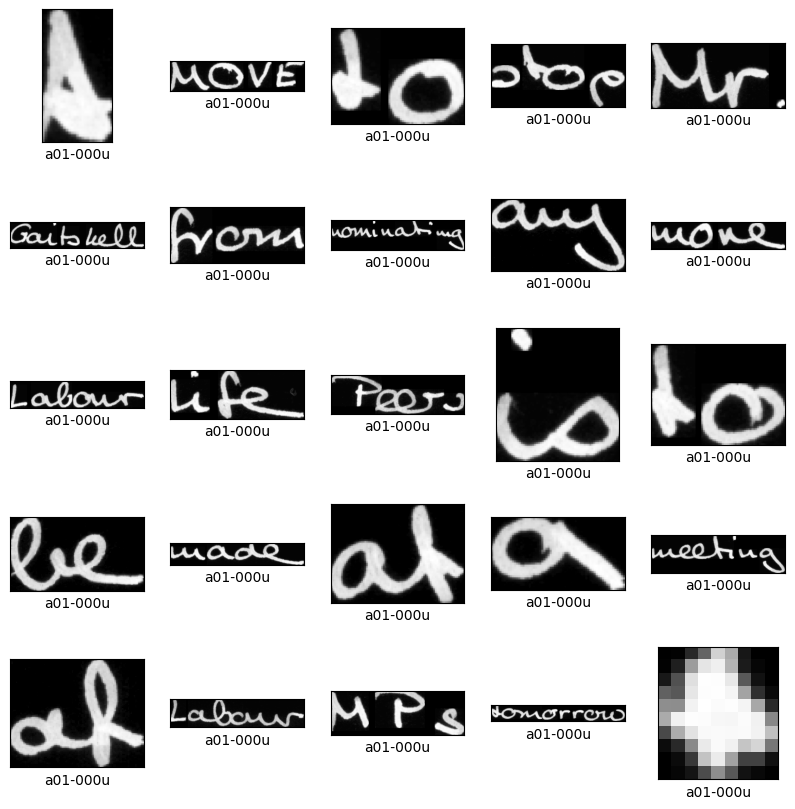

In [8]:
def load_words_data(data_path, metadata_path, selected_writers = []):
    if selected_writers == []:
        raise ValueError("selected_writers must be a non-empty list of writer IDs")

    data = []

    with open(metadata_path, 'r') as file:
        for line in file:
            if not line.startswith("#"):
                components = line.strip().split(' ')
                word_id = components[0]

                parts = word_id.split('-')
                writer_id = '-'.join(parts[:2])

                if writer_id in selected_writers:
                    image_subfolder = parts[0]
                    image_filename = f"{word_id}.png"
                    image_path = os.path.join(data_path, image_subfolder, writer_id, image_filename)

                    if os.path.exists(image_path):
                        try:
                            img = tf.io.read_file(image_path)
                            img = tf.image.decode_png(img)
                            data.append({
                                'image_path': image_path,
                                'writer_id': writer_id,
                                'image_array': img
                            })
                        except tf.errors.InvalidArgumentError:
                            print(f"Image not found for word ID: {word_id} at {image_path}")
                    else:
                        print(f"Image not found for word ID: {word_id} at {image_path}")

    return data

words_data = load_words_data(WORD_DATA_PATH, METADATA_PATH, selected_writers=CLASSES)

if DEBUG:
  print(f"Loaded {len(words_data)} words.")
  for entry in words_data[:5]:
      print(f"  Writer ID: {entry['writer_id']}; image shape: {entry['image_array'].shape}")

if DEBUG:
    print("number of writers: ", len(set([entry['writer_id'] for entry in words_data])))

if DEBUG:
  plt.figure(figsize=(10, 10))
  for i in range(25):
      plt.subplot(5, 5, i + 1)
      plt.xticks([])
      plt.yticks([])
      plt.grid(False)
      plt.imshow(words_data[i]['image_array'], cmap=plt.cm.binary)
      plt.xlabel(words_data[i]['writer_id'])
  plt.show()


**Pre-processing**

In [9]:
def preprocess_data(data):
    labels = []
    images = []

    for entry in data:
        # Resize the image
        img = tf.image.resize(entry['image_array'], [IMAGE_HEIGHT, IMAGE_WIDTH])
        # TODO: Add [random] paddding

        # TODO: divide by average pixel value
        img = img.numpy().astype('float32') / 255.0  # Normalize and convert to float32
        images.append(img)

        labels.append(entry['writer_id'])

    return np.array(images), np.array(labels)


images, labels = preprocess_data(words_data)

In [10]:
# data augmentation

data_generator = keras.preprocessing.image.ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=False,
    fill_mode='nearest'
)

**Kfold**

In [11]:
# Define number of splits
n_splits = 5

# Create Kfold instance
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

**Set function to use kfold**

In [12]:
def train_and_evaluate(model, X_train, y_train, X_test, y_test):
  BATCH_SIZE = 8 # fine tuned
  EPOCHS = 20

  train_generator = data_generator.flow(X_train, y_train, batch_size=BATCH_SIZE)

  class_weights = sku.compute_class_weight(
      class_weight='balanced',
      classes=np.unique(integer_class_labels),
      y=integer_class_labels
  )
  class_weights_dict = {i : weight for i, weight in enumerate(class_weights)}

  early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
  history = model.fit(
      train_generator,
      epochs=EPOCHS,
      steps_per_epoch=len(X_train) // BATCH_SIZE,  # Number of batches per epoch
      validation_data=(X_test, y_test),
      class_weight=class_weights_dict,
      callbacks=[early_stopping]
  )

  ############

  feature_layer = model.get_layer(FLATTEN_LAYER_NAME).output

  # Create a feature extractor model
  feature_extractor_model = keras.models.Model(inputs=model.input, outputs=feature_layer)

  # Now you can use this model to extract features
  features = feature_extractor_model.predict(X_train)

  ############

  # features = model.predict(X_train)

  if DEBUG:
      print(f"features shape: {features.shape}")

  # Standardize the features
  scaler = skp.StandardScaler()
  features_standardized = scaler.fit_transform(features)

  # Now, use the standardized features with UMAP

  def evaluate_model(n_neighbors, min_dist, ax):
      reducer = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, n_components=32, metric='euclidean')
      embedding = reducer.fit_transform(np.nan_to_num(features_standardized))

      sc = ax.scatter(embedding[:, 0], embedding[:, 1],
                      c=integer_class_labels, edgecolor='none', alpha=0.5,
                      cmap=plt.cm.get_cmap('Accent', N_CLASSES))
      ax.set_xlabel('UMAP component 1')
      ax.set_ylabel('UMAP component 2')
      ax.set_title(f'n_neighbors={n_neighbors}, min_dist={min_dist}')

      if n_neighbors == n_neighbors_list[-1] and min_dist == min_dist_list[-1]:
          plt.colorbar(sc, ax=ax)

  n_neighbors_list = [10, 20, 30]
  min_dist_list = [0.0, 0.1, 0.2]

  fig, axes = plt.subplots(len(n_neighbors_list), len(min_dist_list), figsize=(15, 12))

  axes = axes.flatten()

  for idx, (n_neighbors, min_dist) in enumerate([(x, y) for x in n_neighbors_list for y in min_dist_list]):
      evaluate_model(n_neighbors, min_dist, axes[idx])

  plt.tight_layout()
  plt.show()

**Use kfold**


Fold 1 - Training set: X_train shape = (89, 128, 128, 1), y_train shape = (89, 2)
Fold 1 - Testing set: X_test shape = (23, 128, 128, 1), y_test shape = (23, 2)
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 1)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 128, 128, 32)         320       ['input_1[0][0]']             
                                                                                                  
 conv2d_2 (Conv2D)           (None, 128, 128, 32)         832       ['input_1[0][0]']             
                                                                                                  
 max_pooling2d (MaxPooling2  (N

<ipython-input-12-c877c7b7da9f>:53: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=plt.cm.get_cmap('Accent', N_CLASSES))
<ipython-input-12-c877c7b7da9f>:53: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=plt.cm.get_cmap('Accent', N_CLASSES))
<ipython-input-12-c877c7b7da9f>:53: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=plt.cm.get_cmap('Accent', N_CLASSES))
<ipython-input-12-c877c7b7da9f>:53: MatplotlibDeprecationWarning: The get_cmap function was deprecated in 

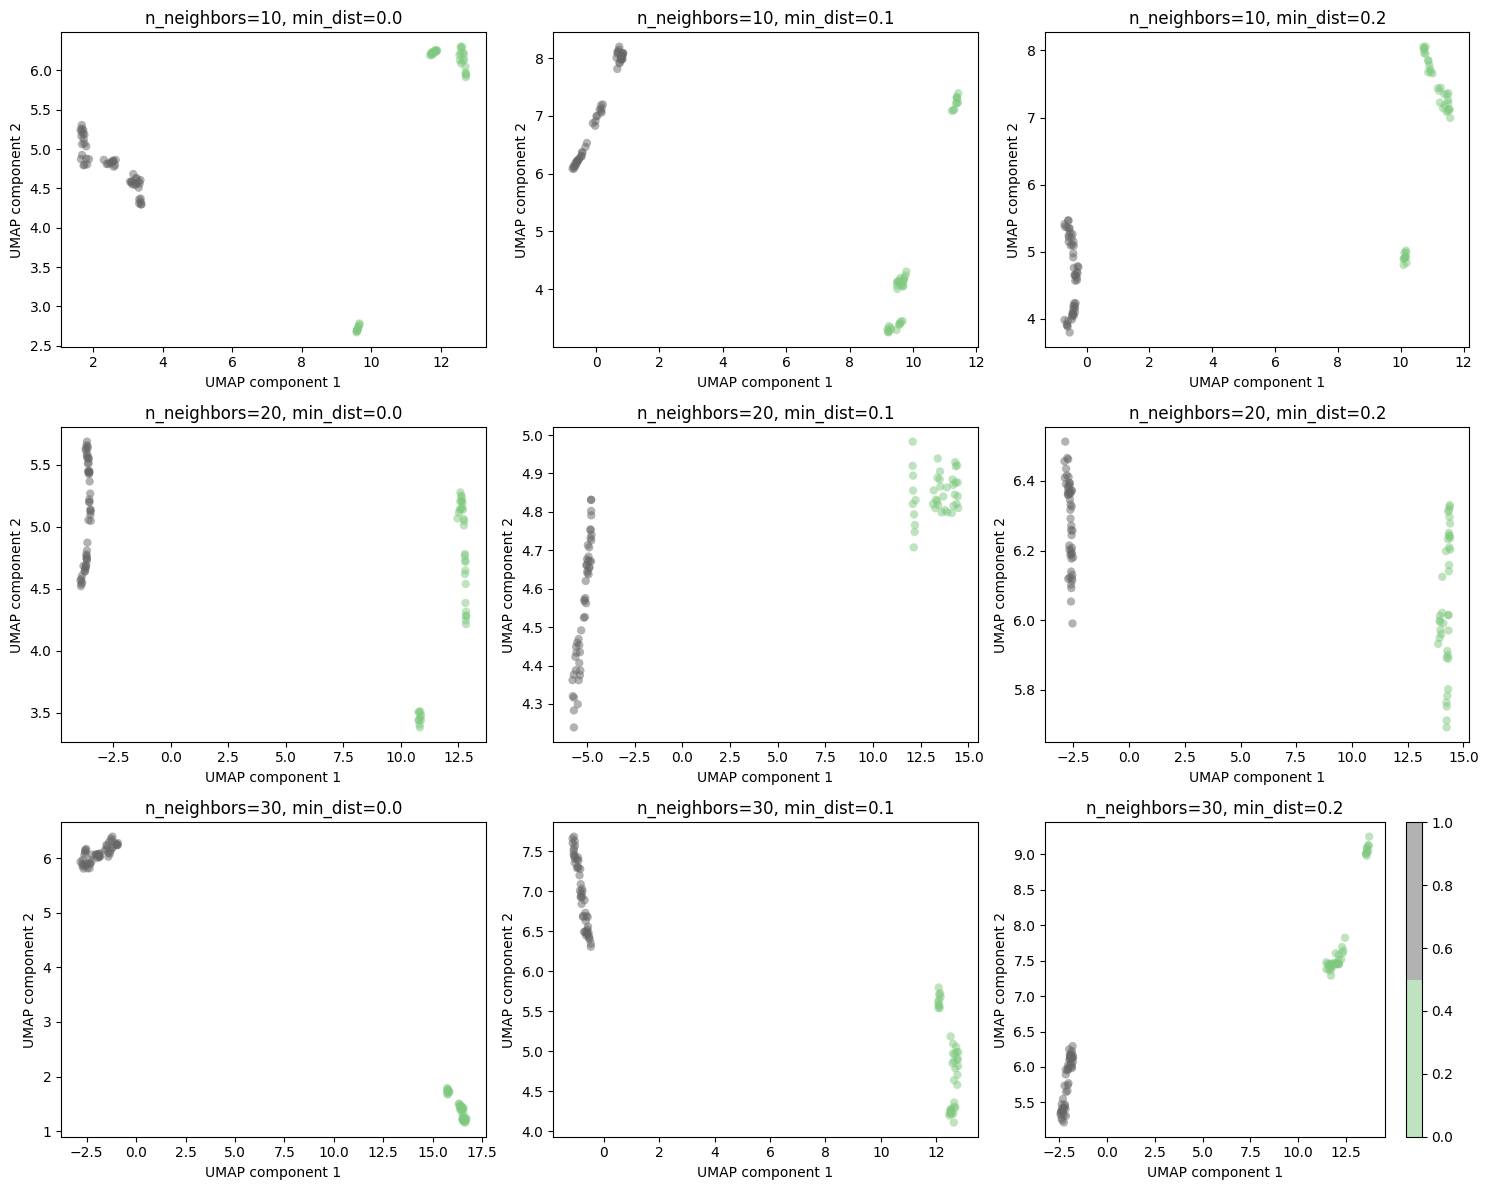


Fold 2 - Training set: X_train shape = (89, 128, 128, 1), y_train shape = (89, 2)
Fold 2 - Testing set: X_test shape = (23, 128, 128, 1), y_test shape = (23, 2)
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 128, 128, 1)]        0         []                            
                                                                                                  
 conv2d_4 (Conv2D)           (None, 128, 128, 32)         320       ['input_2[0][0]']             
                                                                                                  
 conv2d_6 (Conv2D)           (None, 128, 128, 32)         832       ['input_2[0][0]']             
                                                                                                  
 max_pooling2d_4 (MaxPoolin  

<ipython-input-12-c877c7b7da9f>:53: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=plt.cm.get_cmap('Accent', N_CLASSES))
<ipython-input-12-c877c7b7da9f>:53: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=plt.cm.get_cmap('Accent', N_CLASSES))
<ipython-input-12-c877c7b7da9f>:53: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=plt.cm.get_cmap('Accent', N_CLASSES))
<ipython-input-12-c877c7b7da9f>:53: MatplotlibDeprecationWarning: The get_cmap function was deprecated in 

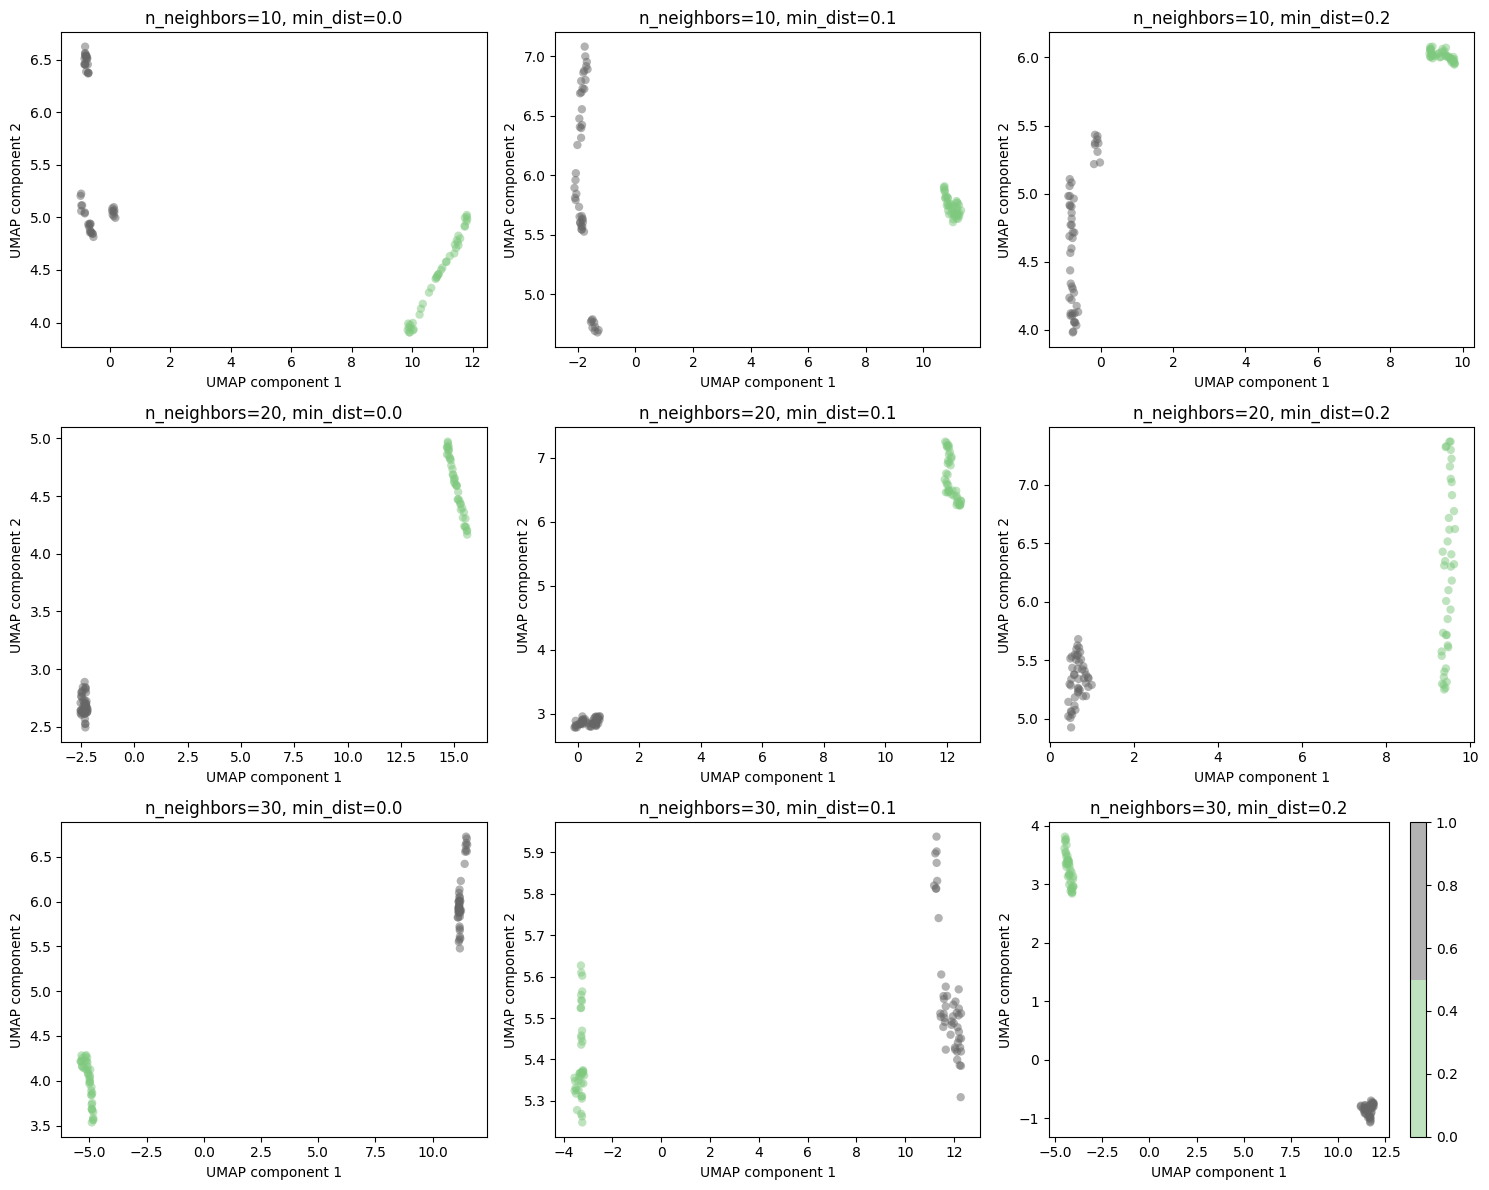


Fold 3 - Training set: X_train shape = (90, 128, 128, 1), y_train shape = (90, 2)
Fold 3 - Testing set: X_test shape = (22, 128, 128, 1), y_test shape = (22, 2)
Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 128, 128, 1)]        0         []                            
                                                                                                  
 conv2d_8 (Conv2D)           (None, 128, 128, 32)         320       ['input_3[0][0]']             
                                                                                                  
 conv2d_10 (Conv2D)          (None, 128, 128, 32)         832       ['input_3[0][0]']             
                                                                                                  
 max_pooling2d_8 (MaxPoolin  

<ipython-input-12-c877c7b7da9f>:53: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=plt.cm.get_cmap('Accent', N_CLASSES))
<ipython-input-12-c877c7b7da9f>:53: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=plt.cm.get_cmap('Accent', N_CLASSES))
<ipython-input-12-c877c7b7da9f>:53: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=plt.cm.get_cmap('Accent', N_CLASSES))
<ipython-input-12-c877c7b7da9f>:53: MatplotlibDeprecationWarning: The get_cmap function was deprecated in 

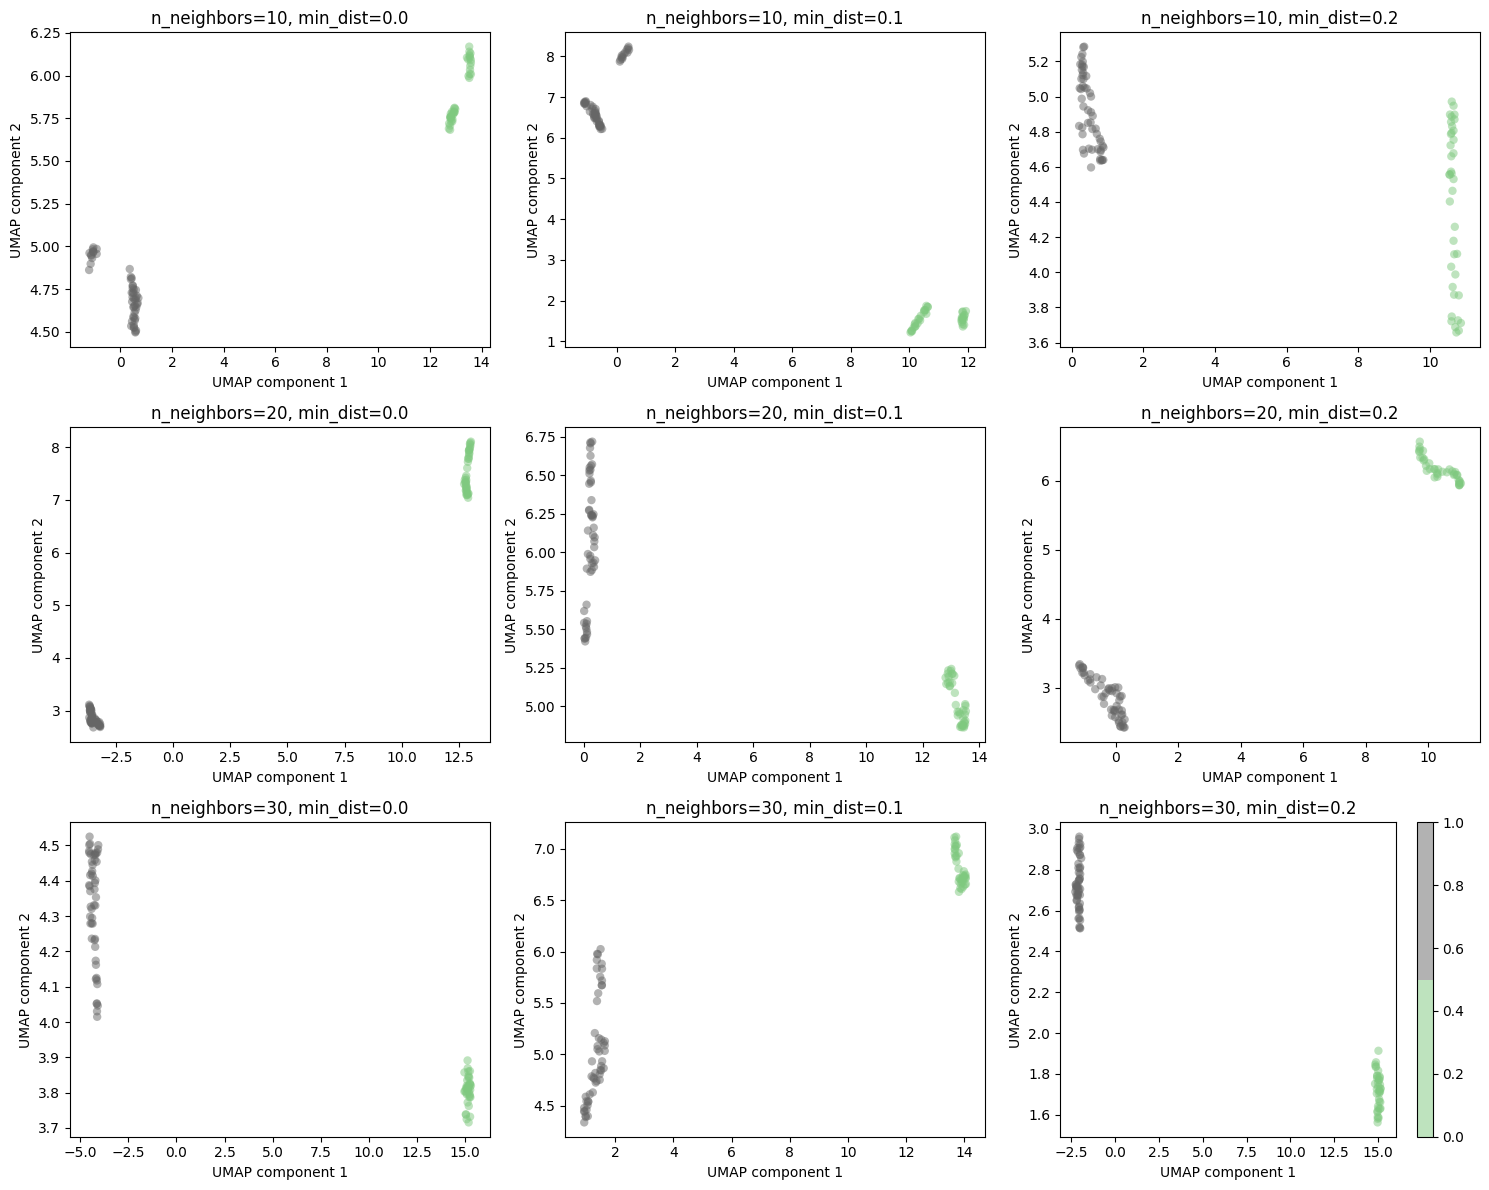


Fold 4 - Training set: X_train shape = (90, 128, 128, 1), y_train shape = (90, 2)
Fold 4 - Testing set: X_test shape = (22, 128, 128, 1), y_test shape = (22, 2)
Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 128, 128, 1)]        0         []                            
                                                                                                  
 conv2d_12 (Conv2D)          (None, 128, 128, 32)         320       ['input_4[0][0]']             
                                                                                                  
 conv2d_14 (Conv2D)          (None, 128, 128, 32)         832       ['input_4[0][0]']             
                                                                                                  
 max_pooling2d_12 (MaxPooli  

<ipython-input-12-c877c7b7da9f>:53: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=plt.cm.get_cmap('Accent', N_CLASSES))
<ipython-input-12-c877c7b7da9f>:53: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=plt.cm.get_cmap('Accent', N_CLASSES))
<ipython-input-12-c877c7b7da9f>:53: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=plt.cm.get_cmap('Accent', N_CLASSES))
<ipython-input-12-c877c7b7da9f>:53: MatplotlibDeprecationWarning: The get_cmap function was deprecated in 

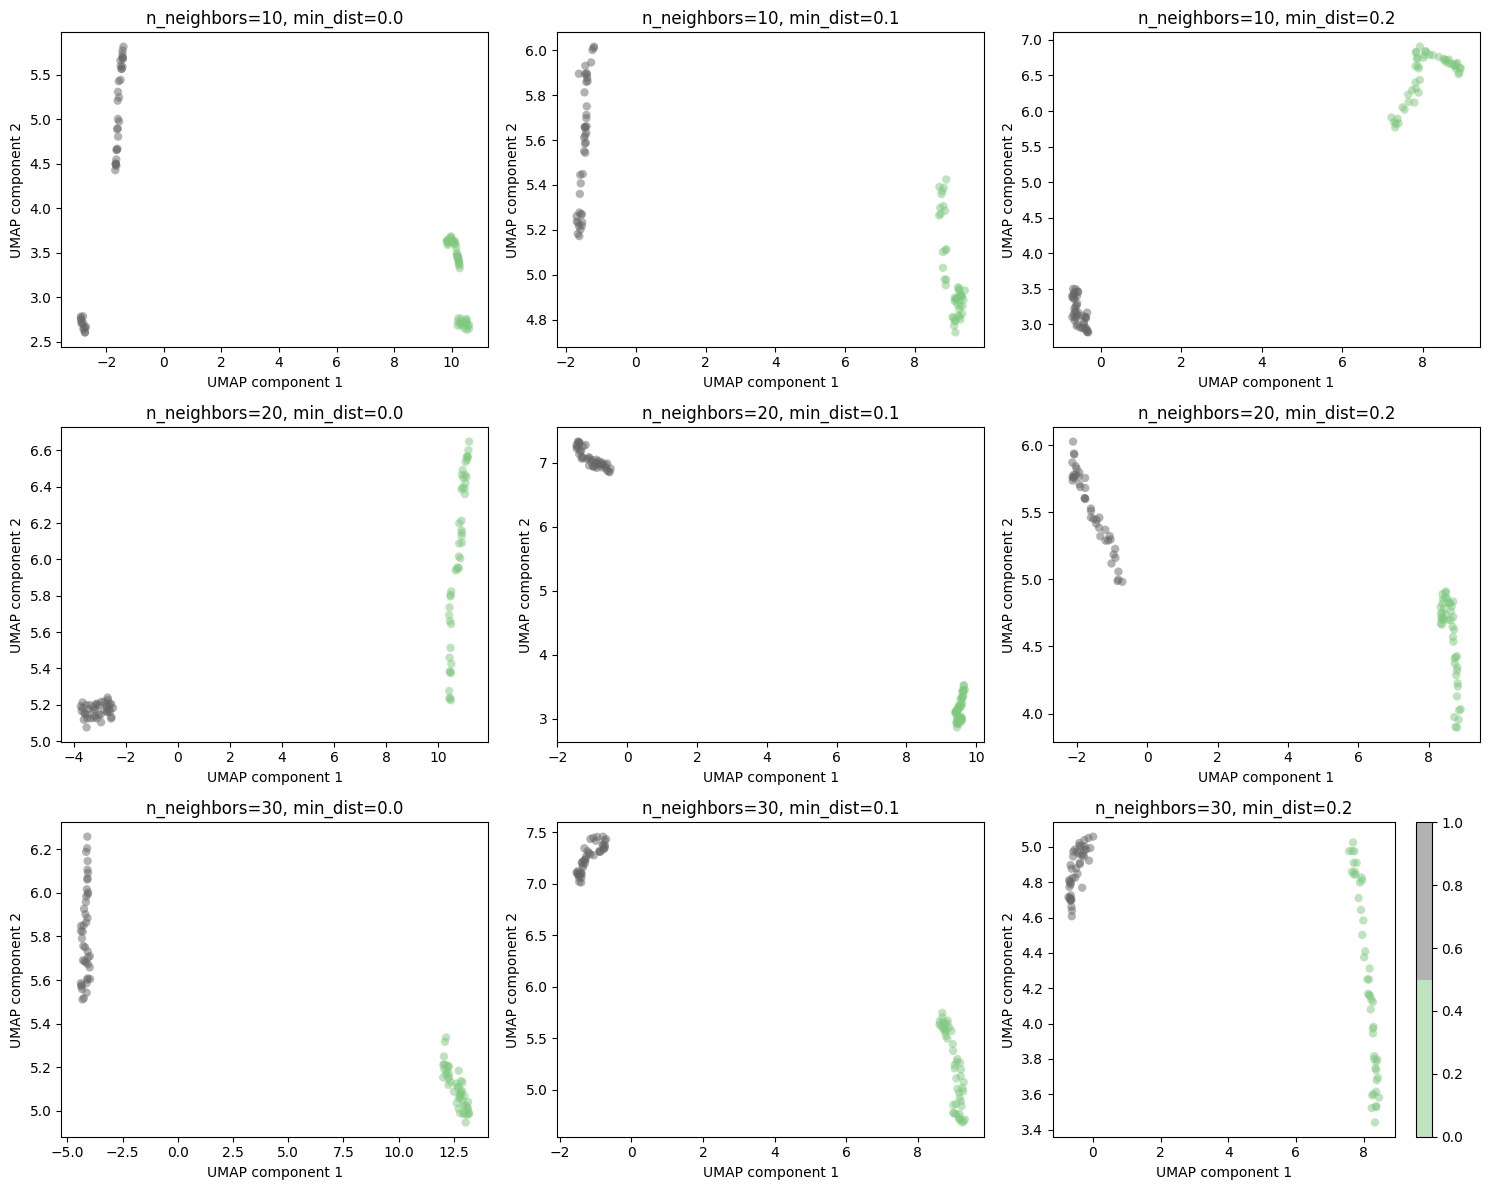


Fold 5 - Training set: X_train shape = (90, 128, 128, 1), y_train shape = (90, 2)
Fold 5 - Testing set: X_test shape = (22, 128, 128, 1), y_test shape = (22, 2)
Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 128, 128, 1)]        0         []                            
                                                                                                  
 conv2d_16 (Conv2D)          (None, 128, 128, 32)         320       ['input_5[0][0]']             
                                                                                                  
 conv2d_18 (Conv2D)          (None, 128, 128, 32)         832       ['input_5[0][0]']             
                                                                                                  
 max_pooling2d_16 (MaxPooli  

3/3 [==============================] - 0s 9ms/step
features shape: (90, 128)


<ipython-input-12-c877c7b7da9f>:53: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=plt.cm.get_cmap('Accent', N_CLASSES))
<ipython-input-12-c877c7b7da9f>:53: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=plt.cm.get_cmap('Accent', N_CLASSES))
<ipython-input-12-c877c7b7da9f>:53: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=plt.cm.get_cmap('Accent', N_CLASSES))
<ipython-input-12-c877c7b7da9f>:53: MatplotlibDeprecationWarning: The get_cmap function was deprecated in 

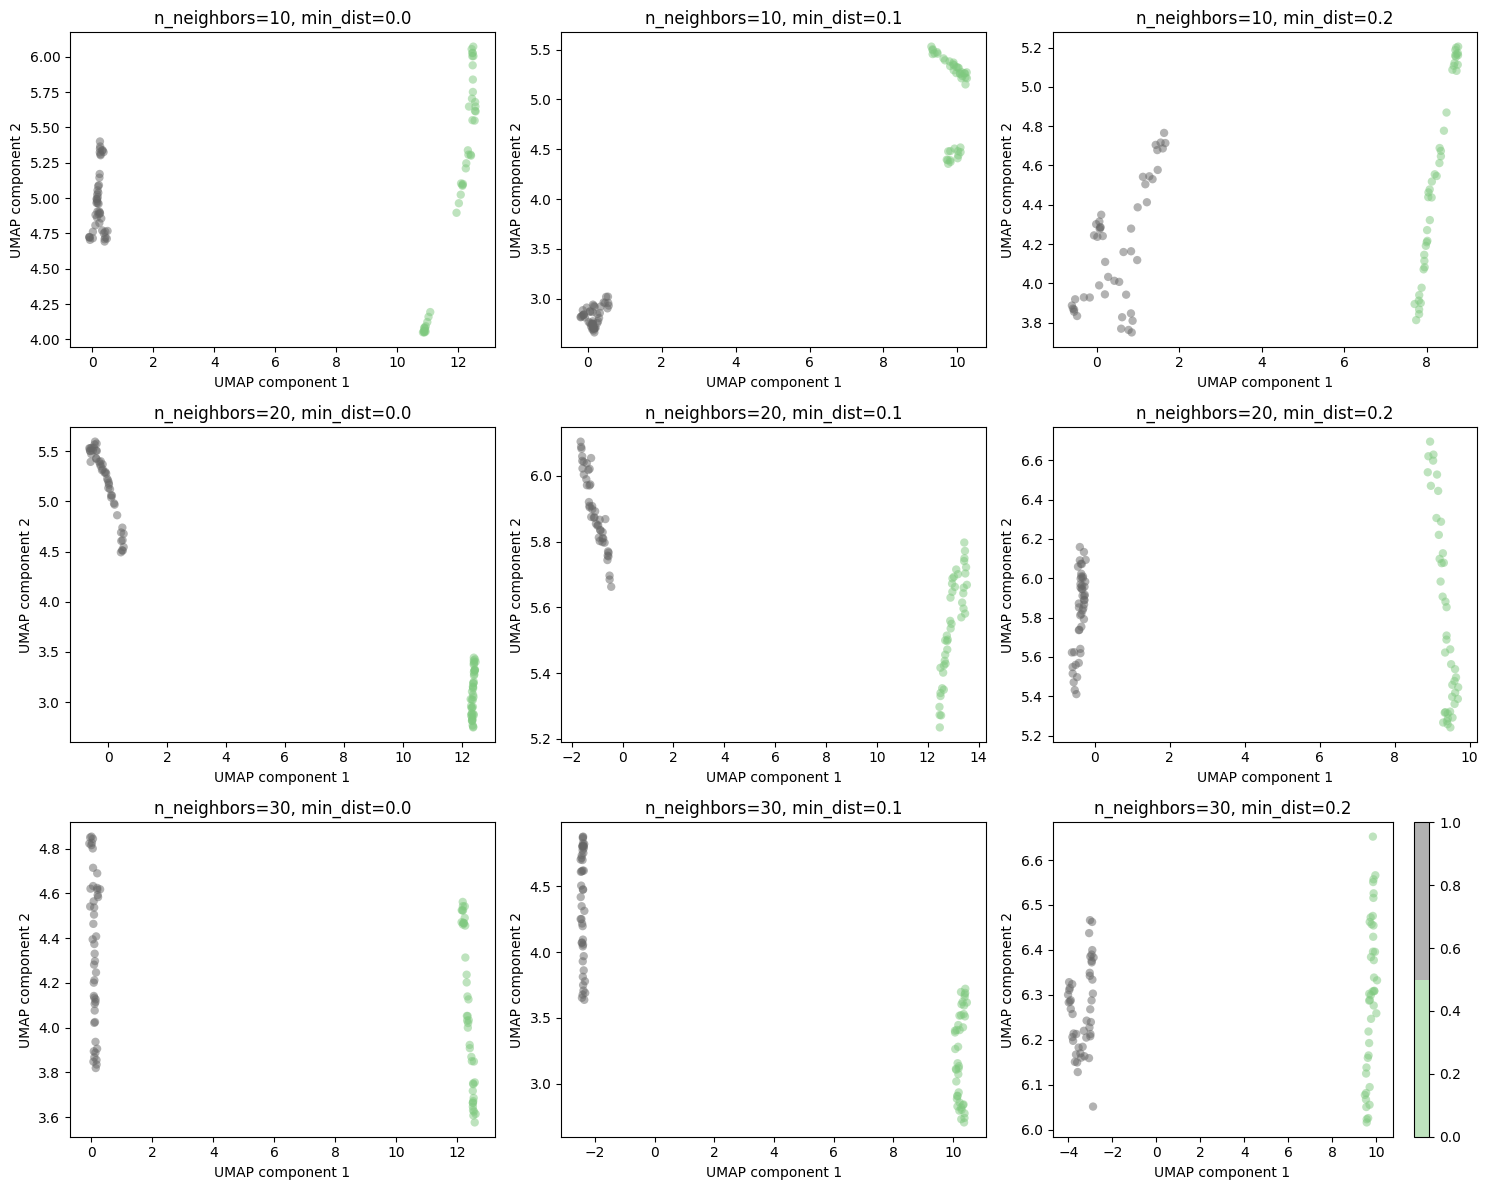

In [17]:
# Execute kfold
for fold, (train_index, test_index) in enumerate(kf.split(images), 1):

    # encode labels
    label_encoder = skp.LabelEncoder()
    integer_encoded_labels = label_encoder.fit_transform(labels)
    one_hot_encoded_labels = keras.utils.to_categorical(integer_encoded_labels)

    X_train, X_test = images[train_index], images[test_index]
    y_train, y_test = one_hot_encoded_labels[train_index], one_hot_encoded_labels[test_index]

    print(f"\nFold {fold} - Training set: X_train shape = {X_train.shape}, y_train shape = {y_train.shape}")
    print(f"Fold {fold} - Testing set: X_test shape = {X_test.shape}, y_test shape = {y_test.shape}")

    integer_class_labels = np.argmax(y_train, axis=1)

    ############

    # Define modele
    input_layer = keras.layers.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 1))

    # Define L1 and L2 regularization
    l1_l2 = keras.regularizers.l1_l2(l1=0, l2=1e-4)

    # path 1
    conv1_1 = keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=l1_l2)(input_layer)
    pool1_1 = keras.layers.MaxPooling2D((2, 2))(conv1_1)
    conv1_2 = keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l1_l2)(pool1_1)
    pool1_2 = keras.layers.MaxPooling2D((2, 2))(conv1_2)

    # path 2
    conv2_1 = keras.layers.Conv2D(32, (5, 5), activation='relu', padding='same', kernel_regularizer=l1_l2)(input_layer)
    pool2_1 = keras.layers.MaxPooling2D((2, 2))(conv2_1)
    conv2_2 = keras.layers.Conv2D(64, (5, 5), activation='relu', padding='same', kernel_regularizer=l1_l2)(pool2_1)
    pool2_2 = keras.layers.MaxPooling2D((2, 2))(conv2_2)

    # merge paths
    merged = keras.layers.concatenate([pool1_2, pool2_2])

    flat = keras.layers.Flatten()(merged)
    dense1 = keras.layers.Dense(128, activation='relu', kernel_regularizer=l1_l2, name=FLATTEN_LAYER_NAME)(flat)
    dropout = keras.layers.Dropout(0.2)(dense1)  # Consider experimenting with the dropout rate
    output_layer = keras.layers.Dense(N_CLASSES, activation='softmax')(dropout)

    model = keras.models.Model(inputs=input_layer, outputs=output_layer)


    if DEBUG:
        model.summary()

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    ############

    # Train and test modele
    train_and_evaluate(model, X_train, y_train, X_test, y_test)